# Assignment 1

In this assignment, you'll be working with messy medical data and using regex to extract relevant infromation from the data. 

Each line of the `dates.txt` file corresponds to a medical note. Each note has a date that needs to be extracted, but each date is encoded in one of many formats.

The goal of this assignment is to correctly identify all of the different date variants encoded in this dataset and to properly normalize and sort the dates. 

Here is a list of some of the variants you might encounter in this dataset:
* 04/20/2009; 04/20/09; 4/20/09; 4/3/09
* Mar-20-2009; Mar 20, 2009; March 20, 2009;  Mar. 20, 2009; Mar 20 2009;
* 20 Mar 2009; 20 March 2009; 20 Mar. 2009; 20 March, 2009
* Mar 20th, 2009; Mar 21st, 2009; Mar 22nd, 2009
* Feb 2009; Sep 2009; Oct 2010
* 6/2008; 12/2009
* 2009; 2010

Once you have extracted these date patterns from the text, the next step is to sort them in ascending chronological order accoring to the following rules:
* Assume all dates in xx/xx/xx format are mm/dd/yy
* Assume all dates where year is encoded in only two digits are years from the 1900's (e.g. 1/5/89 is January 5th, 1989)
* If the day is missing (e.g. 9/2009), assume it is the first day of the month (e.g. September 1, 2009).
* If the month is missing (e.g. 2010), assume it is the first of January of that year (e.g. January 1, 2010).
* Watch out for potential typos as this is a raw, real-life derived dataset.

With these rules in mind, find the correct date in each note and return a pandas Series in chronological order of the original Series' indices. **This Series should be sorted by a tie-break sort in the format of ("extracted date", "original row number").**

For example if the original series was this:

    0    1999
    1    2010
    2    1978
    3    2015
    4    1985

Your function should return this:

    0    2
    1    4
    2    0
    3    1
    4    3

Your score will be calculated using [Kendall's tau](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient), a correlation measure for ordinal data.

*This function should return a Series of length 500 and dtype int.*

In [22]:
import pandas as pd

doc = []
with open('assets/dates.txt') as file:
    for line in file:
        doc.append(line)

df = pd.Series(doc)
df.head(10)

0         03/25/93 Total time of visit (in minutes):\n
1                       6/18/85 Primary Care Doctor:\n
2    sshe plans to move as of 7/8/71 In-Home Servic...
3                7 on 9/27/75 Audit C Score Current:\n
4    2/6/96 sleep studyPain Treatment Pain Level (N...
5                    .Per 7/06/79 Movement D/O note:\n
6    4, 5/18/78 Patient's thoughts about current su...
7    10/24/89 CPT Code: 90801 - Psychiatric Diagnos...
8                         3/7/86 SOS-10 Total Score:\n
9             (4/10/71)Score-1Audit C Score Current:\n
dtype: object

In [23]:
import pandas as pd
import numpy as np 
import re

# Load the data
doc = []
with open('assets/dates.txt') as file:
    for line in file:
        doc.append(line)

df = pd.Series(doc)

def date_sorter():
    # Extract dates like mm/dd/yy (2-digit year)
    a1_1 = df.str.extractall(r'(\d{1,2})[/-](\d{1,2})[/-](\d{2})\b')
    
    # Extract dates like mm/dd/yyyy (4-digit year)
    a1_2 = df.str.extractall(r'(\d{1,2})[/-](\d{1,2})[/-](\d{4})\b')
    
    # Combine both formats and keep original line numbers
    a1 = pd.concat([a1_1, a1_2])
    a1.reset_index(inplace=True)
    a1_index = a1['level_0']

    # Extract formats like "March 20, 2009" or "Mar 20, 2009"
    a2 = df.str.extractall(r'((?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*[-.]* )((?:\d{1,2}[?:, -]*)\d{4})')
    a2.reset_index(inplace=True)
    a2_index = a2['level_0']

    # Extract formats like "20 March 2009"
    a3 = df.str.extractall(r'((?:\d{1,2} ))?((?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*[?:, -]* )(\d{4})')
    a3.reset_index(inplace=True)
    a3_index = a3['level_0']

    # Extract formats like "6/2008"
    a6 = df.str.extractall(r'(\d{1,2})[/](\d{4})')
    a6.reset_index(inplace=True)
    a6_index = a6['level_0']

    # Exclude rows already handled in a1
    save = [i for i in a6_index if i not in a1_index.values]
    a6 = a6[a6['level_0'].isin(save)]

    # Extract formats like "2009" (year only)
    a7_1 = df.str.extractall(r'[a-z]?[^0-9](\d{4})[^0-9]')
    a7_2 = df.str.extractall(r'^(\d{4})[^0-9]')
    a7 = pd.concat([a7_1, a7_2])
    a7.reset_index(inplace=True)
    a7_index = a7['level_0']

    # Exclude overlaps with a2, a3, a6
    save = [i for i in a7_index if i not in a2_index.values and i not in a3_index.values and i not in a6_index.values]
    a7 = a7[a7['level_0'].isin(save)]

    # Combine indices from all extracted groups
    s = a1.level_0.values.tolist() + a2.level_0.values.tolist() + a3.level_0.values.tolist() + a6.level_0.values.tolist() + a7.level_0.values.tolist()
    s = np.asarray(s)

    # Format columns of each group properly
    a1.columns = ['level_0', 'match', 'month', 'day', 'year']
    a1['year'] = a1['year'].apply(str)
    a1['year'] = a1['year'].apply(lambda x: '19'+x if len(x) <= 2 else x)

    a2[1] = a2[1].apply(lambda x: x.replace(',', ''))
    a2['day'] = a2[1].apply(lambda x: x.split(' ')[0])
    a2['year'] = a2[1].apply(lambda x: x.split(' ')[1])
    a2.columns = ['level_0', 'match', 'month', 'day-year', 'day', 'year']
    a2.drop('day-year', axis=1, inplace=True)

    a3.columns = ['level_0', 'match', 'day', 'month', 'year']
    a3['day'] = a3['day'].replace(np.nan, -99)
    a3['day'] = a3['day'].apply(lambda x: 1 if int(x) == -99 else x)
    a3['month'] = a3.month.apply(lambda x: x[:3])
    a3['month'] = pd.to_datetime(a3.month, format='%b').dt.month

    a6.columns = ['level_0', 'match', 'month', 'year']
    a6['day'] = 1

    a7.columns = ['level_0', 'match', 'year']
    a7['day'] = 1
    a7['month'] = 1

    # Merge all cleaned date parts
    final = pd.concat([a1, a2, a3, a6, a7])

    # Build datetime column
    final['date'] = pd.to_datetime(final['month'].apply(str) + '/' + final['day'].apply(str) + '/' + final['year'].apply(str))

    # Sort by original row number and then by date
    final = final.sort_values(by='level_0').set_index('level_0')

    # Create the final sorted index list
    myList = final['date']
    answer = pd.Series([i[0] for i in sorted(enumerate(myList), key=lambda x: x[1])], np.arange(500))
    
    return answer, final

In [24]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

In [25]:
result, final = date_sorter()
print(result.head())

0     9
1    84
2     2
3    53
4    28
dtype: int64


In [26]:
result, final = date_sorter()
print(df.iloc[result[:10]])

9               (4/10/71)Score-1Audit C Score Current:\n
84           5/18/71 Total time of visit (in minutes):\n
2      sshe plans to move as of 7/8/71 In-Home Servic...
53                         7/11/71 SOS-10 Total Score:\n
28                                9/12/71 [report_end]\n
474    sPatient reported losing three friends that pa...
153                   13 Jan 1972 Primary Care Doctor:\n
13     1/26/72 Communication with referring physician...
129                    06 May 1972 SOS-10 Total Score:\n
98     5/13/72 Other Adult Mental Health Outcomes Sca...
dtype: object


In [27]:
# Re-run to get sorted result
result, final = date_sorter()

# Open output file to write
with open("sorted_dates_output.txt", "w") as f:
    f.write("Sorted dates with line content:\n\n")
    
    for rank, line_index in enumerate(result):
        line_content = df[line_index].strip()
        f.write(f"{rank+1:>3}. Line {line_index}: {line_content}\n")

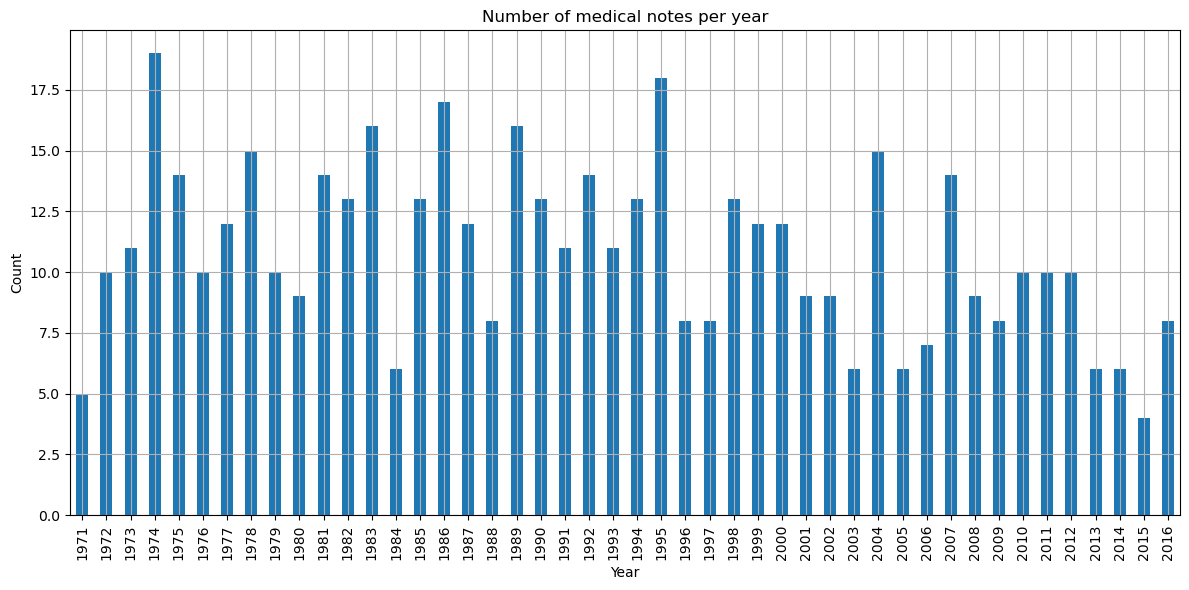

In [28]:
import matplotlib.pyplot as plt

# Add year column
final['year'] = final['date'].dt.year

# Count entries per year
year_counts = final['year'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')
plt.title('Number of medical notes per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()